In [ ]:
# === Cell 1: Thiết lập + hàm dựng feature theo ngày từ đăng ký (học viên vào muộn) ===
import logging
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.preprocessing import PowerTransformer

DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]
CUTOFFS = [7, 14, 30, 60, 90, 120, 150, 180]
WINDOW_DAYS = 14
HALF_WINDOW = 7
VAR_THRESH = 0.0
MODEL_PATH = "dropout_model_relative.pkl"

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")


def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    return {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
        "student_ass": pd.read_csv(data_dir / "studentAssessment.csv"),
        "assessments": pd.read_csv(data_dir / "assessments.csv"),
    }


def prepare_students(raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]):
    reg_mod = raw["student_reg"][
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations))
    ]
    reg_lookup = reg_mod[["id_student", "date_registration"]].drop_duplicates()

    students = raw["student_info"][
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_lookup["id_student"]))
    ].copy()
    students["dropout"] = (students["final_result"] == "Withdrawn").astype(int)

    vle_mod = raw["student_vle"][
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations))
    ].merge(reg_lookup, on="id_student", how="inner")
    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]

    ass_mod = raw["student_ass"].merge(reg_lookup, on="id_student", how="inner")
    ass_mod["days_since_reg"] = ass_mod["date_submitted"] - ass_mod["date_registration"]

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    return students, vle_mod, ass_mod


def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    if not days_list:
        return end_day - start_day + 1
    active = set(days_list)
    streak, d = 0, end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak


def build_features_relative(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    ass_mod: pd.DataFrame,
    assessments: pd.DataFrame,
    cutoffs: List[int],
    window_days: int = WINDOW_DAYS,
    half_window: int = HALF_WINDOW,
):
    target_assessment_ids = assessments["id_assessment"].unique()
    augmented = []

    for cutoff in cutoffs:
        w_start = max(0, cutoff - (window_days - 1))
        w_end = cutoff

        vle_cum = vle_mod[vle_mod["days_since_reg"] <= cutoff].copy()
        vle_win = vle_cum[vle_cum["days_since_reg"] >= w_start].copy()

        cum_agg = (
            vle_cum.groupby("id_student")
            .agg(
                total_clicks=("sum_click", "sum"),
                active_days_total=("days_since_reg", "nunique"),
                last_active=("days_since_reg", "max"),
            )
            .reset_index()
        )
        cum_agg["days_elapsed_since_reg"] = cutoff
        cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
        cum_agg["active_ratio_total"] = cum_agg["active_days_total"] / max(cutoff, 1)
        cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
        cum_agg["avg_clicks_per_active_day_total"] = (
            cum_agg["total_clicks"] / cum_agg["active_days_total"].replace(0, np.nan)
        ).fillna(0)

        win_agg = (
            vle_win.groupby("id_student")
            .agg(clicks_last_14_days=("sum_click", "sum"), active_days_14=("days_since_reg", "nunique"))
            .reset_index()
        )
        win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / window_days
        win_agg["active_ratio_14"] = win_agg["active_days_14"] / window_days

        first_end = min(w_end, w_start + (half_window - 1))
        second_start = min(w_end, first_end + 1)

        clicks_0_7 = (
            vle_win[(vle_win["days_since_reg"] >= w_start) & (vle_win["days_since_reg"] <= first_end)]
            .groupby("id_student")["sum_click"]
            .sum()
            .reset_index(name="clicks_0_7")
        )
        clicks_8_14 = (
            vle_win[(vle_win["days_since_reg"] >= second_start) & (vle_win["days_since_reg"] <= w_end)]
            .groupby("id_student")["sum_click"]
            .sum()
            .reset_index(name="clicks_8_14")
        )

        clicks_last_7 = (
            vle_cum[vle_cum["days_since_reg"] > (cutoff - 7)]
            .groupby("id_student")["sum_click"]
            .sum()
            .reset_index(name="clicks_last_7_days")
        )

        days_list = (
            vle_win.groupby("id_student")["days_since_reg"]
            .apply(lambda x: sorted(x.unique()))
            .reset_index()
            .rename(columns={"days_since_reg": "active_days_list"})
        )
        days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
            lambda lst: compute_inactivity_streak(lst, w_start, w_end)
        )
        streak = days_list[["id_student", "inactivity_streak_14"]]

        ass_cum = ass_mod[
            (ass_mod["id_assessment"].isin(target_assessment_ids))
            & (ass_mod["date_submitted"].notna())
            & (ass_mod["days_since_reg"] <= cutoff)
        ].copy()

        ass_agg = (
            ass_cum.groupby("id_student")
            .agg(
                num_assessments=("id_assessment", "nunique"),
                avg_score=("score", "mean"),
                pass_count=("score", lambda x: (x >= 40).sum()),
                last_score=("score", "last"),
            )
            .reset_index()
        )

        ass_win = ass_cum[ass_cum["days_since_reg"] >= w_start]
        ass_agg_14 = (
            ass_win.groupby("id_student")
            .agg(num_assessments_14=("id_assessment", "nunique"), avg_score_14=("score", "mean"))
            .reset_index()
        )

        base = students[["id_student", "dropout"]].copy()
        merged = base.merge(cum_agg, on="id_student", how="left")
        merged = merged.merge(win_agg, on="id_student", how="left")
        merged = merged.merge(clicks_0_7, on="id_student", how="left")
        merged = merged.merge(clicks_8_14, on="id_student", how="left")
        merged = merged.merge(clicks_last_7, on="id_student", how="left")
        merged = merged.merge(streak, on="id_student", how="left")
        merged = merged.merge(ass_agg, on="id_student", how="left")
        merged = merged.merge(ass_agg_14, on="id_student", how="left")

        fill0 = [
            "total_clicks",
            "active_days_total",
            "last_active",
            "clicks_last_14_days",
            "active_days_14",
            "clicks_0_7",
            "clicks_8_14",
            "clicks_last_7_days",
            "inactivity_streak_14",
            "num_assessments",
            "avg_score",
            "pass_count",
            "last_score",
            "num_assessments_14",
            "avg_score_14",
        ]
        for col in fill0:
            merged[col] = merged[col].fillna(0)

        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)
        merged["days_elapsed_since_reg"] = cutoff

        augmented.append(merged)

    final_df = pd.concat(augmented, ignore_index=True)
    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",
        "clicks_last_14_days",
        "active_days_14",
        "clicks_per_day_14",
        "active_ratio_14",
        "clicks_last_7_days",
        "clicks_0_7",
        "clicks_8_14",
        "trend_click_14",
        "ratio_click_14",
        "inactivity_streak_14",
       
    ]
    return final_df, feature_cols


def make_eval_pipe(model):
    return ImbPipeline(
        [
            ("variance_threshold", VarianceThreshold(VAR_THRESH)),
            ("smote", SMOTE()),
            ("power_transformer", PowerTransformer()),
            ("classifier", model),
        ]
    )


def make_prod_pipe(model):
    return SkPipeline(
        [
            ("variance_threshold", VarianceThreshold(VAR_THRESH)),
            ("power_transformer", PowerTransformer()),
            ("classifier", model),
        ]
    )


MODELS = {
    "GradientBoostingClassifier": GradientBoostingClassifier(
        learning_rate=0.03,
        loss="exponential",
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=10,
        n_iter_no_change=10,
        random_state=42
    ),
   "RandomForestClassifier": RandomForestClassifier(
    criterion="gini",
    max_depth=10,         # Tăng từ 3 lên 10 (hoặc 12)
    min_samples_leaf=5,   # Giảm từ 10 xuống 5 (để học chi tiết hơn)
    min_samples_split=10, # Giảm xuống 10
    n_estimators=200,     # Tăng lên 200 cây
    random_state=42,
    n_jobs=-1,
    # class_weight="balanced" # Có thể thử bỏ dòng này nếu muốn tăng Accuracy (giảm Recall chút)
),
    "MLPClassifier": MLPClassifier(
        alpha=0.1,
        early_stopping=True,
        hidden_layer_sizes=(135,),
        learning_rate="constant",
        learning_rate_init=0.3,
        max_iter=1200,
        momentum=0.9,
        solver="sgd",
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=2000,
        random_state=42
    )
}


In [12]:
# === Cell 2: Train/eval 5-fold, chọn model tốt nhất, lưu pipeline, in top 10 rủi ro ===
raw = load_raw(DATA_DIR)
students, vle_mod, ass_mod = prepare_students(raw, MODULE, PRESENTATIONS)

final_df, feature_cols = build_features_relative(students, vle_mod, ass_mod, raw["assessments"], CUTOFFS)
X = final_df[feature_cols].fillna(0)
y = final_df["dropout"].astype(int)
groups = final_df["id_student"]

gkf = GroupKFold(n_splits=5)
summary_rows = []
for name, model in MODELS.items():
    fold_rows = []
    for tr_idx, te_idx in gkf.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        pipe = make_eval_pipe(model)
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)
        y_proba = pipe.predict_proba(X_te)[:, 1]
        fold_rows.append({
            "model": name,
            "accuracy": accuracy_score(y_te, y_pred),
            "f1": f1_score(y_te, y_pred),
            "recall": recall_score(y_te, y_pred),
            "specificity": recall_score(y_te, y_pred, pos_label=0),
            "auc": roc_auc_score(y_te, y_proba),
        })
    df = pd.DataFrame(fold_rows)
    summary_rows.append({
        "model": name,
        "mean_accuracy": df["accuracy"].mean(),
        "mean_f1": df["f1"].mean(),
        "mean_recall": df["recall"].mean(),
        "mean_specificity": df["specificity"].mean(),
        "mean_auc": df["auc"].mean(),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("mean_f1", ascending=False)
print("Hiệu năng trung bình (sort theo F1):\n", summary_df)

best_model = summary_df.iloc[0]["model"]
prod_pipe = make_prod_pipe(MODELS[best_model])
prod_pipe.fit(X, y)
joblib.dump(prod_pipe, MODEL_PATH)
print(f"Đã lưu model vào {MODEL_PATH} với model {best_model}")

latest_cutoff = max(CUTOFFS)
today_df = final_df[final_df["days_elapsed_since_reg"] == latest_cutoff].copy()
today_df["dropout_proba"] = prod_pipe.predict_proba(today_df[feature_cols])[:, 1]

[2025-12-25 15:45:01,706] INFO - So hoc vien hop le: 3960
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use

Hiệu năng trung bình (sort theo F1):
                         model  mean_accuracy   mean_f1  mean_recall  \
1      RandomForestClassifier       0.594997  0.533223     0.807237   
0  GradientBoostingClassifier       0.576796  0.530454     0.834178   
3          LogisticRegression       0.577296  0.528672     0.827283   
2               MLPClassifier       0.615498  0.521909     0.735077   

   mean_specificity  mean_auc  
1          0.509446  0.724346  
0          0.472972  0.713616  
3          0.476425  0.708032  
2          0.568371  0.717004  
Đã lưu model vào dropout_model_relative.pkl với model RandomForestClassifier
Đã lưu model vào dropout_model_relative.pkl với model RandomForestClassifier


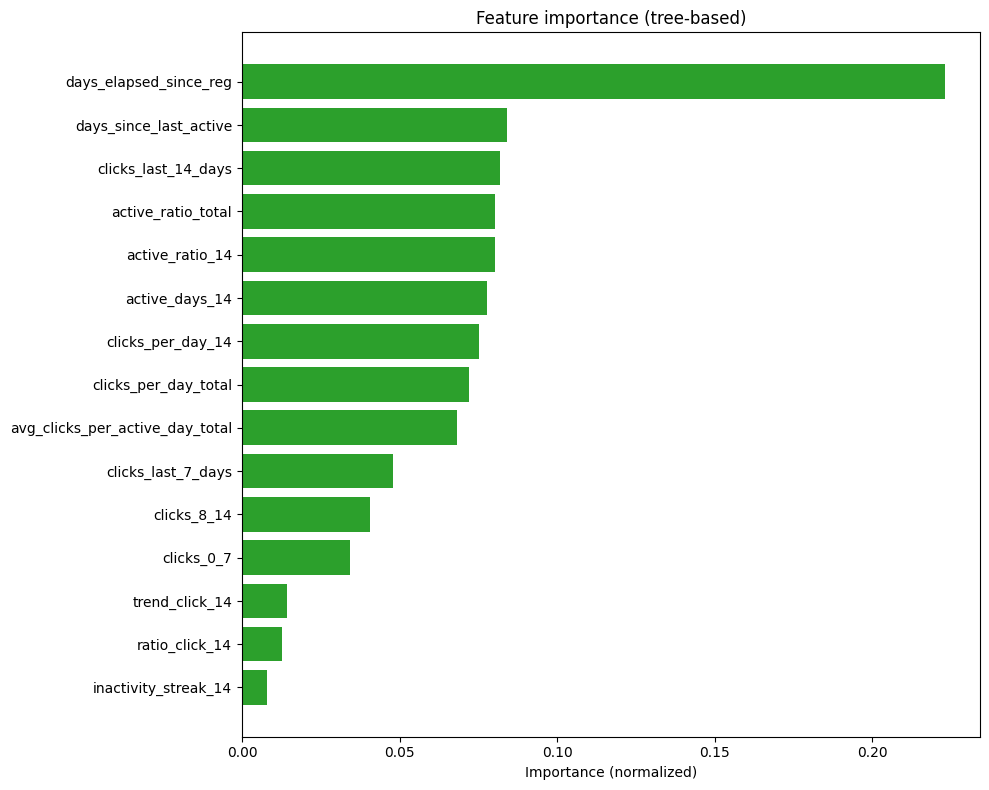

,feature,importance
0,days_elapsed_since_reg,0.222963
4,days_since_last_active,0.084137
5,clicks_last_14_days,0.081754
2,active_ratio_total,0.080334
8,active_ratio_14,0.080303
6,active_days_14,0.077720
7,clicks_per_day_14,0.075306
1,clicks_per_day_total,0.072117
3,avg_clicks_per_active_day_total,0.068119
9,clicks_last_7_days,0.047767


In [13]:
# === Cell 3: Phân tích độ quan trọng đặc trưng của model đã chọn ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Lấy classifier đã train
clf = prod_pipe.named_steps["classifier"]
feat_names = feature_cols

def plot_importance(features: pd.DataFrame, title: str):
    features = features.sort_values("importance", ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(features["feature"], features["importance"], color="#2ca02c")
    plt.xlabel("Importance (normalized)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 1) Tree-based: dùng feature_importances_ nếu có
if hasattr(clf, "feature_importances_"):
    imp = clf.feature_importances_
    fi_df = pd.DataFrame({"feature": feat_names[: len(imp)], "importance": imp})
    plot_importance(fi_df, "Feature importance (tree-based)")

# 2) Linear (Logistic Regression): dùng |coef| chuẩn hóa
elif hasattr(clf, "coef_"):
    coef = np.abs(clf.coef_).ravel()
    coef = coef / (np.sum(coef) + 1e-9)
    fi_df = pd.DataFrame({"feature": feat_names[: len(coef)], "importance": coef})
    plot_importance(fi_df, "Feature importance (|coef| normalized)")

# 3) Nếu model khác: dùng permutation importance để tham khảo (có thể hơi chậm)
else:
    result = permutation_importance(prod_pipe, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    imp = result.importances_mean
    fi_df = pd.DataFrame({"feature": feat_names[: len(imp)], "importance": imp})
    plot_importance(fi_df, "Permutation importance")

fi_df.sort_values("importance", ascending=False).head(15)


=== GradientBoostingClassifier ===


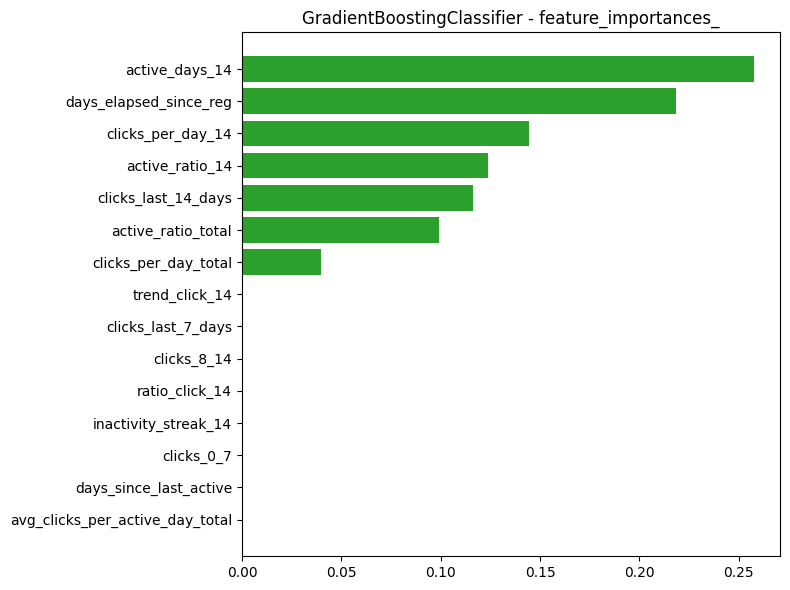

                            feature  importance
6                    active_days_14    0.257830
0            days_elapsed_since_reg    0.218238
7                 clicks_per_day_14    0.144543
8                   active_ratio_14    0.123682
5               clicks_last_14_days    0.116395
2                active_ratio_total    0.099271
1              clicks_per_day_total    0.039691
12                   trend_click_14    0.000349
4            days_since_last_active    0.000000
3   avg_clicks_per_active_day_total    0.000000

=== RandomForestClassifier ===


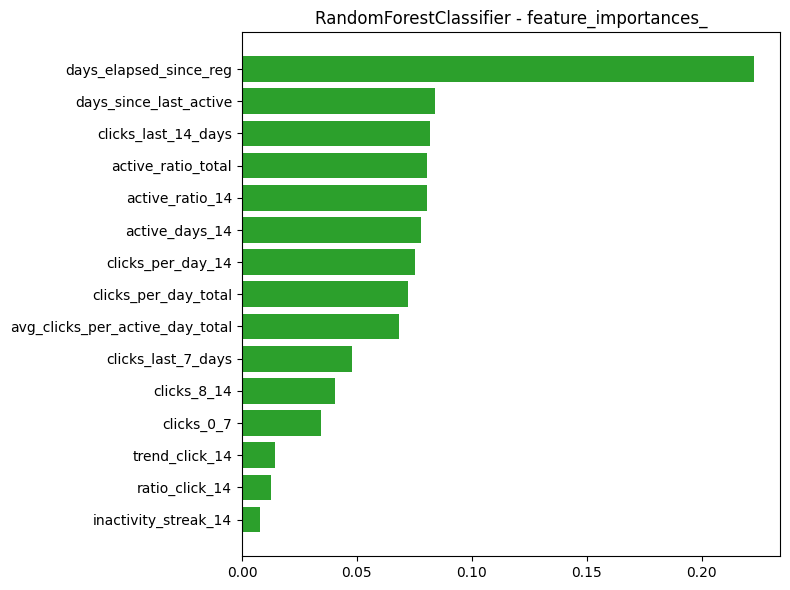

                           feature  importance
0           days_elapsed_since_reg    0.222963
4           days_since_last_active    0.084137
5              clicks_last_14_days    0.081754
2               active_ratio_total    0.080334
8                  active_ratio_14    0.080303
6                   active_days_14    0.077720
7                clicks_per_day_14    0.075306
1             clicks_per_day_total    0.072117
3  avg_clicks_per_active_day_total    0.068119
9               clicks_last_7_days    0.047767

=== MLPClassifier ===


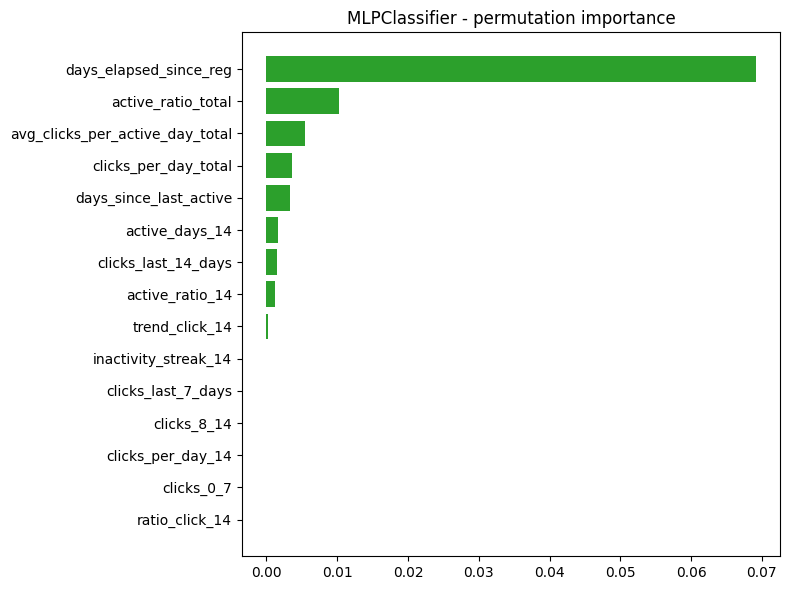

                            feature  importance
0            days_elapsed_since_reg    0.069114
2                active_ratio_total    0.010185
3   avg_clicks_per_active_day_total    0.005385
1              clicks_per_day_total    0.003672
4            days_since_last_active    0.003262
6                    active_days_14    0.001573
5               clicks_last_14_days    0.001444
8                   active_ratio_14    0.001210
12                   trend_click_14    0.000156
9                clicks_last_7_days    0.000000

=== LogisticRegression ===


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


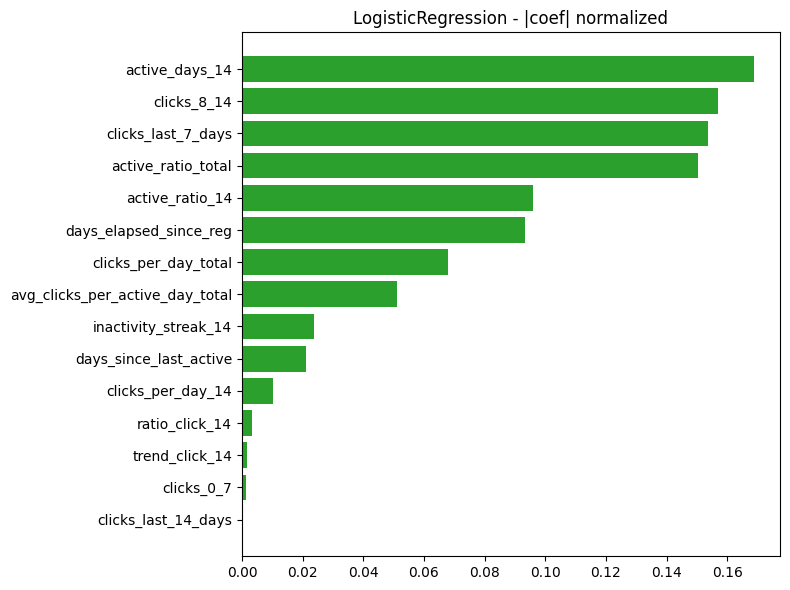

                            feature  importance
6                    active_days_14    0.168969
11                      clicks_8_14    0.157082
9                clicks_last_7_days    0.153517
2                active_ratio_total    0.150344
8                   active_ratio_14    0.096111
0            days_elapsed_since_reg    0.093474
1              clicks_per_day_total    0.068083
3   avg_clicks_per_active_day_total    0.051242
14             inactivity_streak_14    0.023616
4            days_since_last_active    0.021052


In [14]:
# === Cell 4: So sánh độ quan trọng đặc trưng cho cả 4 model ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

results = {}
for name, model in MODELS.items():
    print(f"\n=== {name} ===")
    pipe = make_prod_pipe(model)
    pipe.fit(X, y)
    clf = pipe.named_steps["classifier"]

    def plot_imp(df_imp: pd.DataFrame, title: str):
        df_imp = df_imp.sort_values("importance", ascending=True)
        plt.figure(figsize=(8, 6))
        plt.barh(df_imp["feature"], df_imp["importance"], color="#2ca02c")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        fi_df = pd.DataFrame({"feature": feature_cols[: len(imp)], "importance": imp})
        plot_imp(fi_df, f"{name} - feature_importances_")
    elif hasattr(clf, "coef_"):
        coef = np.abs(clf.coef_).ravel()
        coef = coef / (np.sum(coef) + 1e-9)
        fi_df = pd.DataFrame({"feature": feature_cols[: len(coef)], "importance": coef})
        plot_imp(fi_df, f"{name} - |coef| normalized")
    else:
        result = permutation_importance(pipe, X, y, n_repeats=8, random_state=42, n_jobs=-1)
        imp = result.importances_mean
        fi_df = pd.DataFrame({"feature": feature_cols[: len(imp)], "importance": imp})
        plot_imp(fi_df, f"{name} - permutation importance")

    print(fi_df.sort_values("importance", ascending=False).head(10))
    results[name] = fi_df.sort_values("importance", ascending=False).head(10)